In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style='darkgrid', context='talk', palette='colorblind')

## Keywords

In [2]:
df = pd.read_csv('paperlist.tsv', index_col=0, sep='\t')
print('# papers:', len(df))
df.head()

# papers: 4894


,title,link,keywords,abstract
paper_id,,,,
kRvZ2PcsxjJj,Quantum reinforcement learning,https://openreview.net/forum?id=kRvZ2PcsxjJj,"quantum reinforcement learning, multi-agent, q...",With the rapid development of quantum technolo...
RUzSobdYy0V,Quantifying and Mitigating the Impact of Label...,https://openreview.net/forum?id=RUzSobdYy0V,NaN,Errors in labels obtained via human annotation...
N3kGYG3ZcTi,Suppression helps: Lateral Inhibition-inspired...,https://openreview.net/forum?id=N3kGYG3ZcTi,"Lateral Inhibition, Convolutional Neural Networks",Convolutional neural networks (CNNs) have beco...
tmIiMPl4IPa,Factorized Fourier Neural Operators,https://openreview.net/forum?id=tmIiMPl4IPa,"fourier transform, fourier operators, pde, nav...",We propose the Factorized Fourier Neural Opera...
mhnHqRqcjYU,DFPC: Data flow driven pruning of coupled chan...,https://openreview.net/forum?id=mhnHqRqcjYU,"Pruning, Data Free, Model Compression",Most structured pruning algorithms achieve sub...


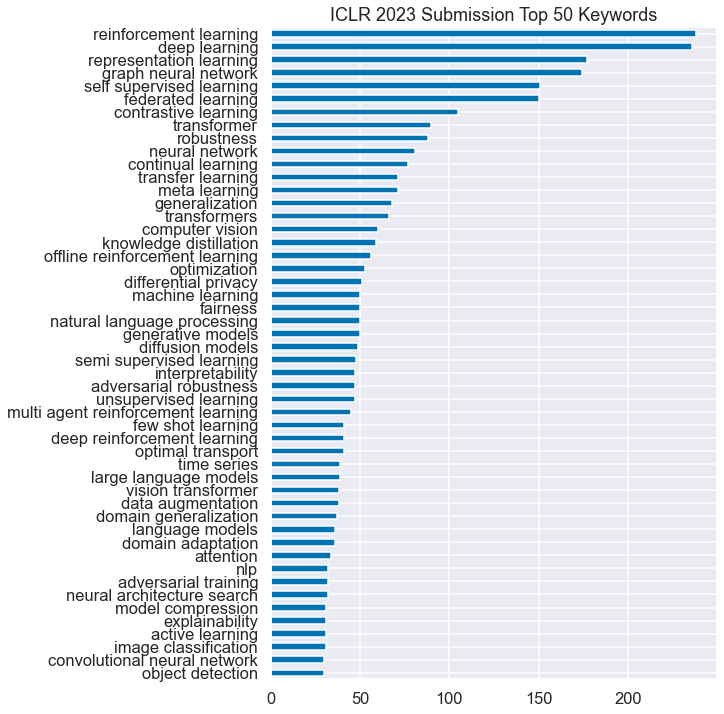

In [3]:
counts = pd.Series(
    ', '.join(df['keywords'].dropna()).lower().replace('-', ' ').replace('networks', 'network').split(',')
).str.strip().value_counts().sort_values(ascending=True)
counts.iloc[-50:].plot.barh(figsize=(8, 12), title='ICLR 2023 Submission Top 50 Keywords')
plt.savefig('asset/keywords.png', dpi=300, bbox_inches='tight')

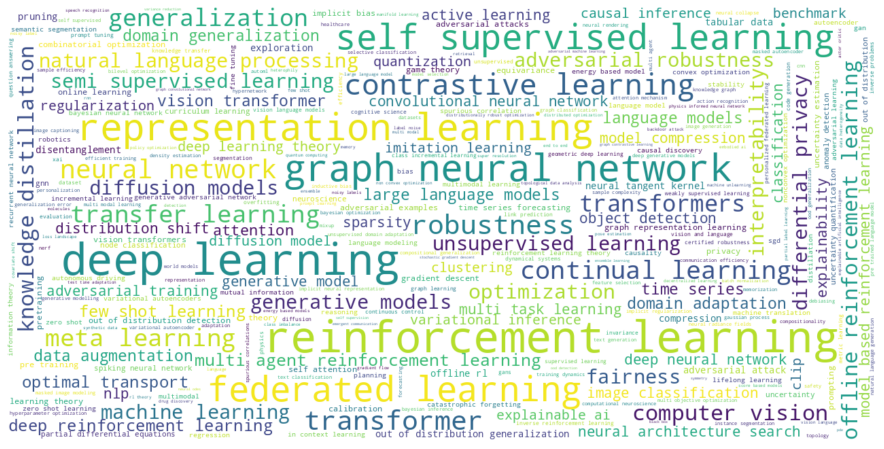

In [7]:
from imageio import imread
from wordcloud import WordCloud

wc = WordCloud(background_color="white", max_words=300, max_font_size=64, 
               width=1280, height=640, random_state=0)
wc.generate_from_frequencies(counts.to_dict())
fig = plt.figure(figsize=(16, 8))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.savefig('asset/wordcloud.png', dpi=300, bbox_inches='tight')

<ipython-input-8-b559710a546c>:4: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  logo = imread('asset/logo.png')


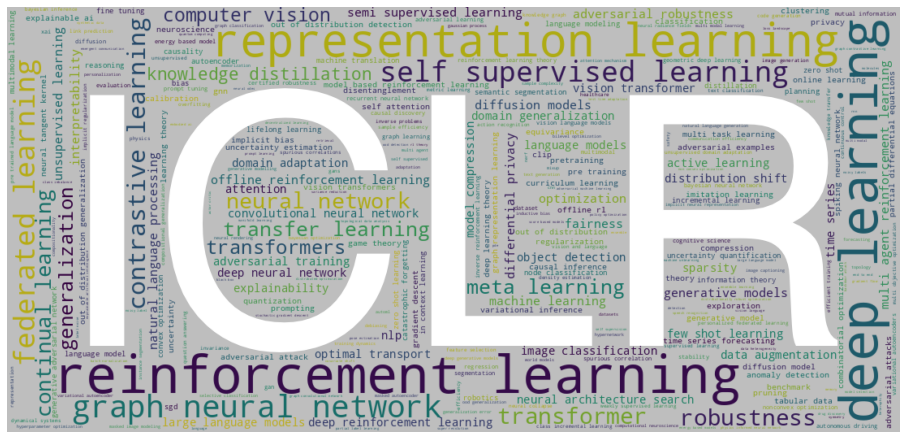

In [8]:
from imageio import imread
from wordcloud import WordCloud

logo = imread('asset/logo.png')
wc = WordCloud(background_color="white", max_words=300, max_font_size=64, 
               width=1280, height=640, random_state=0, mask=logo)
wc.generate_from_frequencies(counts.to_dict())
fig = plt.figure(figsize=(16, 8))
plt.imshow(logo)
plt.imshow(wc, interpolation="bilinear", alpha=.75)
plt.axis("off")
plt.savefig('asset/logo_wordcloud.png', dpi=300, bbox_inches='tight')

## Rating Distributions

In [9]:
ratings = pd.read_csv('ratings.tsv', sep='\t', index_col=0)
print(ratings.iloc[:, :-1].stack().mean())
ratings.head()

4.936507936507937


,0,1,2,3,4,5,6,7,8,decision
paper_id,,,,,,,,,,
kRvZ2PcsxjJj,1.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,Unknown
RUzSobdYy0V,5.0,6.0,8.0,NaN,NaN,NaN,NaN,NaN,NaN,Unknown
N3kGYG3ZcTi,3.0,5.0,3.0,1.0,NaN,NaN,NaN,NaN,NaN,Unknown
tmIiMPl4IPa,8.0,6.0,3.0,8.0,3.0,NaN,NaN,NaN,NaN,Unknown
mhnHqRqcjYU,8.0,6.0,6.0,NaN,NaN,NaN,NaN,NaN,NaN,Unknown


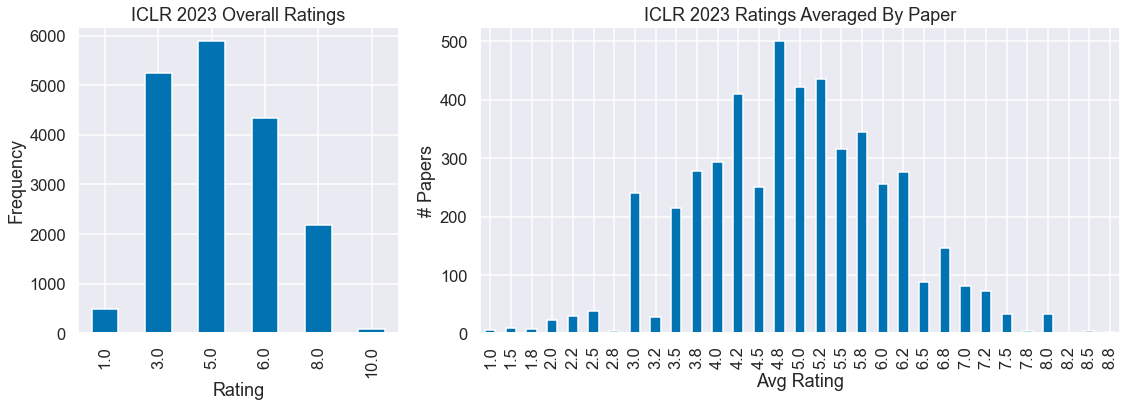

In [13]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6), gridspec_kw={'width_ratios': [1, 2]})
bar_plt1 = ratings.iloc[:, :-1].stack().value_counts().sort_index().plot.bar(
    ax=axes[0], title='ICLR 2023 Overall Ratings')
bar_plt1.set_xlabel('Rating')
bar_plt1.set_ylabel('Frequency')
bar_plt2 = ratings.iloc[:, :-1].mean(axis=1).mul(4).round().div(4).round(1).value_counts().sort_index().plot.bar(
    ax=axes[1], title='ICLR 2023 Ratings Averaged By Paper')
bar_plt2.set_xlabel('Avg Rating')
bar_plt2.set_ylabel('# Papers')
plt.tight_layout()
plt.savefig('asset/ratings_dist.png', dpi=300, bbox_inches='tight')

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


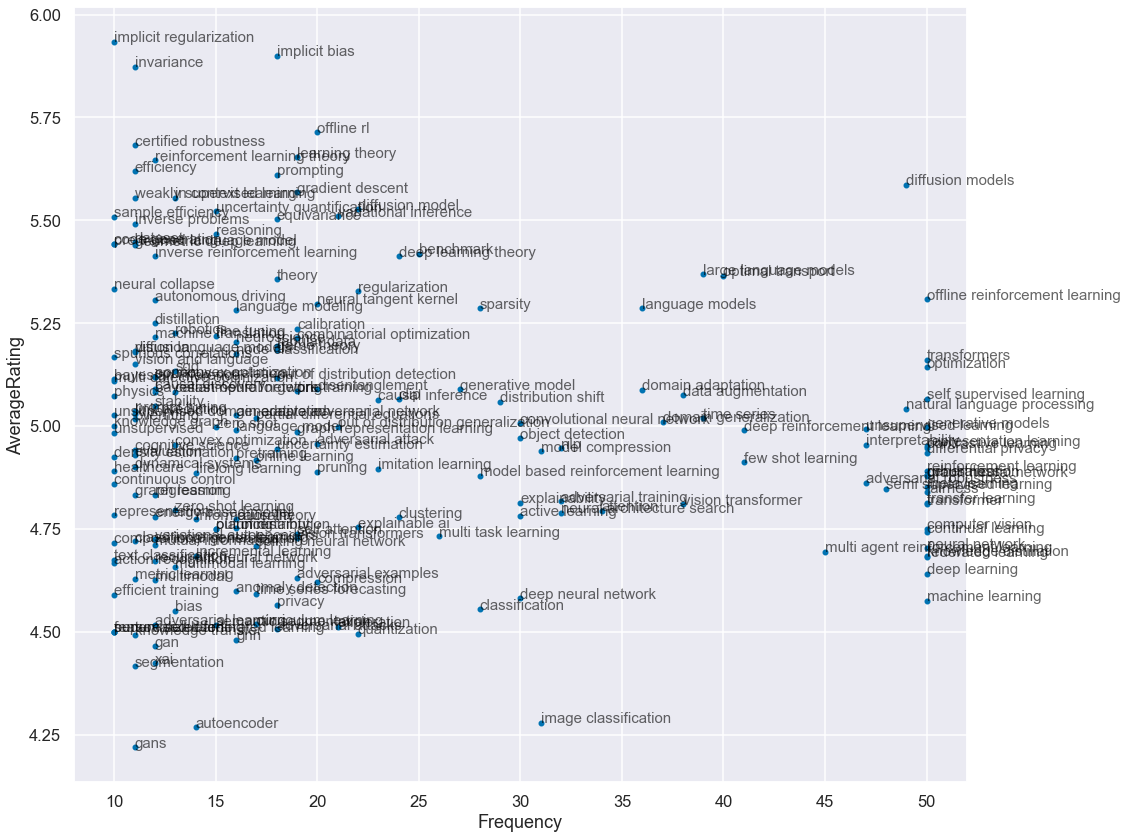

In [14]:
data = {}
for keywords, rating in zip(df.keywords, ratings.iloc[:, :-1].mean(axis=1)):
    if (isinstance(keywords, float) and np.isnan(keywords)) or np.isnan(rating):
        continue
    for keyword in keywords.lower().replace('-', ' ').replace('networks', 'network').split(','):
        data.setdefault(keyword.strip(), []).append(rating)

t = pd.DataFrame({
    'Frequency': [min(len(v), 50) for v in data.values()], # clip to 50
    'AverageRating': [np.mean(v) for v in data.values()],
    'Keyword': list(data.keys())
}).query('Frequency>9')
t.plot.scatter(x='Frequency', y='AverageRating', figsize=(16, 12))

for i in range(len(t)):
     plt.text(t.Frequency.iloc[i], t.AverageRating.iloc[i], t.Keyword.iloc[i], 
              horizontalalignment='left', 
              size='small', color='black', alpha=0.6)

plt.tight_layout()
plt.savefig('asset/keyword_ratings.png', dpi=300, bbox_inches='tight')

## Top 50 Papers

In [15]:
comb_df = pd.DataFrame({
    'AvgRating': ratings.iloc[:, :-1].mean(axis=1).round(2),
    'Title': '[' + df['title'] + ']' + '(' + df['link'] + ')',
    'Ratings': ratings.iloc[:, :-1].apply(lambda x: ', '.join(x.dropna().astype(int).astype(str).values), axis=1),
    'Decision': ratings.iloc[:, -1],
})

comb_df = comb_df.sort_values('AvgRating', ascending=False).reset_index(drop=True)
comb_df.index += 1
comb_df.index.name = 'Rank'
comb_df.head(50)

,AvgRating,Title,Ratings,Decision
Rank,,,,
1,8.67,[Rethinking the Expressive Power of GNNs via G...,"8, 8, 10",Unknown
2,8.67,[Git Re-Basin: Merging Models modulo Permutati...,"8, 8, 10",Unknown
3,8.50,[Graph Neural Networks for Link Prediction wit...,"10, 8, 8, 8",Unknown
4,8.50,[DEP-RL: Embodied Exploration for Reinforcemen...,"8, 8, 8, 10",Unknown
5,8.50,[Emergence of Maps in the Memories of Blind Na...,"10, 8, 8, 8",Unknown
6,8.50,[Revisiting the Entropy Semiring for Neural Sp...,"10, 6, 8, 10",Unknown
7,8.25,"[Understanding Ensemble, Knowledge Distillatio...","5, 10, 10, 8",Unknown
8,8.00,[Can We Find Nash Equilibria at a Linear Rate ...,"8, 8, 8, 8",Unknown
9,8.00,[What learning algorithm is in-context learnin...,"8, 8, 8",Unknown


In [18]:
with open('ranked_papers.md', 'w', encoding='utf8') as f:
    comb_df.to_markdown(f)

## Accepted Oral Papers

In [ ]:
comb_df = pd.DataFrame({
    'AvgRating': ratings.iloc[:, :-1].mean(axis=1).round(2),
    'Title': '[' + df['title'] + ']' + '(' + df['link'] + ')',
    'Ratings': ratings.iloc[:, :-1].apply(lambda x: ', '.join(x.dropna().astype(int).astype(str).values), axis=1),
    'Decision': ratings.iloc[:, -1],
})

comb_df = comb_df[comb_df.Decision == 'Accept (Oral)'].sort_values('AvgRating', ascending=False).reset_index(drop=True)
comb_df.index += 1
comb_df.index.name = 'Rank'
comb_df

In [15]:
with open('accepted_oral.md', 'w', encoding='utf8') as f:
    comb_df.to_markdown(f)